In [74]:
import math
import matplotlib.pyplot as plt
import cupy as np
import numpy as tnp
import random
import matplotlib.cm as cm
import matplotlib as mpl
import itertools
import functools
from numpy.random import choice, rand
from numpy import linalg as LA
import scipy
import pandas as pd
from scipy.optimize import minimize

In [75]:
temp = [1,2,3,4]
print(temp[0:1])
print(temp[1:2])
print(temp[2:3])
print(temp[3:4])

[1]
[2]
[3]
[4]


In [76]:
def gram_matrix(Xs):
  temp = tnp.vstack([tnp.ravel(X) for X in Xs],dtype=complex)
  return tnp.dot(temp, temp.T)

def eig(X):
  vals, vecs = np.linalg.eig(X)
  idx = tnp.argsort(tnp.abs(vals))
  return vals[idx], vecs[...,idx]

def eig_both(X):
  # could call ctrevc to get both left and right at once
  return eig(X.T)[1], eig(X)[1]

def nkp_sum(As, Bs):
  """Nearest Kronecker product to a sum of Kronecker products.
  Given As = [A_1, ..., A_K] and Bs = [B_1, ..., B_K], solve
    min || \sum_i kron(A_i, B_i) - kron(Ahat, Bhat) ||_{Fro}^2
  where the minimization is over Ahat and Bhat, two N x N matrices.
  The size of the eigendecomposition computed in this implementation is K x K,
  and so the complexity scales like O(K^3 + K^2 N^2), where K is the length of
  the input lists.
  Args:
    As: list of N x N matrices
    Bs: list of N x N matrices
  Returns:
    Approximating factors (Ahat, Bhat)
  """

  GK = tnp.dot(gram_matrix(As), gram_matrix(Bs))
  lvecs, rvecs = eig_both(GK)
  Ahat = tnp.einsum('i,ijk->jk', lvecs[-1], As)
  Bhat = tnp.einsum('i,ijk->jk', rvecs[-1], Bs)
  return Ahat.reshape(As[0].shape), Bhat.reshape(Bs[0].shape)

def nkp(A, Bshape):
  """Nearest Kronecker product to a matrix.
  Given a matrix A and a shape, solves the problem
    min || A - kron(B, C) ||_{Fro}^2
  where the minimization is over B with (the specified shape) and C.
  The size of the SVD computed in this implementation is the size of the input
  argument A, and so to compare to nkp_sum if the output is two N x N matrices
  the complexity scales like O((N^2)^3) = O(N^6).
  Args:
    A: m x n matrix
    Bshape: pair of ints (a, b) where a divides m and b divides n
  Returns:
    Approximating factors (B, C)
  """

  blocks = map(lambda blockcol: tnp.split(blockcol*(1.0 + 0.0j), Bshape[0], 0),
                                tnp.split(A.get()*(1.0 + 0.0j),        Bshape[1], 1))
  Atilde = tnp.vstack([block.ravel()*(1.0 + 0.0j) for blockcol in blocks
                                    for block in blockcol])
  U, s, V = tnp.linalg.svd(Atilde)
  Cshape = A.shape[0] // Bshape[0], A.shape[1] // Bshape[1]
  idx = tnp.argmax(s)
  B = tnp.sqrt(s[idx]) * U[:,idx].reshape(Bshape).T
  C = tnp.sqrt(s[idx]) * V[idx,:].reshape(Cshape)
  return B, C

In [77]:
#a = np.array([0.70710678+0.j, 0.70710678+0.j]), b = np.array([0.70710678+0.j,  0.5       +0.5j]), print(np.kron(a, b))
a = tnp.array([0.70710678+0.j, 0.70710678+0.j])
b = tnp.array([0.70710678+0.j,  0.5       +0.5j])
#[0.5       +0.j         0.35355339+0.35355339j]
#[0.5       +0.j         0.35355339+0.35355339j]

def performDecomp(matrixInput, matricies):
    if(np.shape(matrixInput)[0] < 4):
        matricies.append(matrixInput)
        return
    matrix = np.column_stack((matrixInput.real,matrixInput.imag,np.zeros(np.shape(matrixInput)[0]),np.zeros(np.shape(matrixInput)[0])))
    a, b = nkp(matrix, (2**math.floor(math.log2(np.shape(matrix)[1])/2), 2))
    a = a[:,0] + a[:,1]*(1.0j)
    b = b[:,0] + b[:,1]*(1.0j)
    matricies.append(a)
    performDecomp(b, matricies)
    return
def findDecomposition(matrix):
    matricies = []
    performDecomp(matrix, matricies)
    matricies = np.array(matricies)
    return matricies

In [78]:
def findNumQubits(matrix):
    return matrix.shape()

In [79]:
numQubits = 4
decomposedState = [np.transpose(np.array([1+ 0.0j,0 + 0.0j])) for i in range(numQubits)]
print(decomposedState)

[array([1.+0.j, 0.+0.j]), array([1.+0.j, 0.+0.j]), array([1.+0.j, 0.+0.j]), array([1.+0.j, 0.+0.j])]


In [80]:
numDepth = 5
circuitOperators = [[['-', [j]] for j in range(numQubits)] for i in range(numDepth)]
circuitOperators[0][0] = ['H', [0]]
circuitOperators[0][1] = ['H', [1]]
circuitOperators[0][2] = ['H', [2]]
circuitOperators[0][3] = ['H', [3]]
circuitOperators[1][3] = ['T', [3]]
circuitOperators[1][2] = ['S', [3]]
circuitOperators[2][0] = ['CNOT', [0,1]]
circuitOperators[2][1] = ['CNOT', [0,1]]
print(circuitOperators)

[[['H', [0]], ['H', [1]], ['H', [2]], ['H', [3]]], [['-', [0]], ['-', [1]], ['S', [3]], ['T', [3]]], [['CNOT', [0, 1]], ['CNOT', [0, 1]], ['-', [2]], ['-', [3]]], [['-', [0]], ['-', [1]], ['-', [2]], ['-', [3]]], [['-', [0]], ['-', [1]], ['-', [2]], ['-', [3]]]]


In [81]:
def printCircuit():
    print("Quantum Circuit Printout:")
    entry = ""
    for depth in range(3*(numDepth+1)):
        entry += "-"
    print(entry)
    for qubit in range(numQubits):
        tempStr = ""
        for depth in range(numDepth):
            if(circuitOperators[depth][qubit][0] == 'CNOT'):
                if(qubit == circuitOperators[depth][qubit][1][0]):
                    tempStr += "[*]"
                else:
                    tempStr += "[x]"
            else:
                tempStr += "[" + circuitOperators[depth][qubit][0] + "]"
        tempStr += "[M]"
        print(tempStr)
    print(entry)
printCircuit()

Quantum Circuit Printout:
------------------
[H][-][*][-][-][M]
[H][-][x][-][-][M]
[H][S][-][-][-][M]
[H][T][-][-][-][M]
------------------


In [82]:
operations = {'H': [np.array([[1/np.sqrt(2) + 0.0j, 1/np.sqrt(2) + 0.0j], [1/np.sqrt(2) + 0.0j, -1/np.sqrt(2) + 0.0j]]),1], '-': [np.array([[1, 0], [0,1]]),1],
             'CNOT': [np.array([[1+ 0.0j,0+ 0.0j,0+ 0.0j,0+ 0.0j],[0+ 0.0j,1+ 0.0j,0+ 0.0j,0+ 0.0j],[0+ 0.0j,0+ 0.0j,0+ 0.0j,1+ 0.0j],[0+ 0.0j,0+ 0.0j,1+ 0.0j,0+ 0.0j]]), 2], 'X': [np.array([[0 + 0.0j, 1+ 0.0j],[1+ 0.0j,0+ 0.0j]]),1], 'Y': [np.array([[0+ 0.0j, 0-1j],[0+1j, 0+ 0.0j]]), 1],
             'Z': [np.array([[1+ 0.0j, 0+ 0.0j],[0+ 0.0j,-1+ 0.0j]]), 1], 'S': [np.array([[1+ 0.0j,0+ 0.0j],[0+ 0.0j,0+1j]]), 1], 'T': [np.array([[1+ 0.0j,0+ 0.0j],[0+ 0.0j,0+tnp.exp(1j*np.pi/4)]]),1]}

In [83]:
qubitToIndex = [j for j in range(numQubits)]
qubitsInvolvedInIndex = [[j] for j in range(numQubits)]
print(qubitToIndex)
type([])

[0, 1, 2, 3]


list

In [84]:
a = np.array([0.70710678+0.j, 0.70710678+0.j])
b = np.array([0.70710678+0.j,  0.5       +0.5j])
print(np.kron(a, b))

[0.5       +0.j         0.35355339+0.35355339j 0.5       +0.j
 0.35355339+0.35355339j]


In [85]:
def getTensor(depth):
    initalTensor = np.array([1])
    index = 0
    for entry in circuitOperators[depth]:
        if(min(entry[1]) == index):
            initalTensor = np.kron(initalTensor, operations[entry[0]][0])
        index += 1
    return initalTensor
print(getTensor(2))
print(np.shape(getTensor(2)))

stateProbabilities = []
initalState = np.zeros(numQubits)
initalState[0] = 1
history = ["".join(seq) for seq in itertools.product("01", repeat=numQubits)]
arrayHistory = [(np.fromstring(entry,'u1') - ord('0'))*(1.0+0.0j) for entry in history]
for qubit in range(numQubits):
    probabilityTotal = 0.0
    for possiblePrior in arrayHistory:
        pass

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j

In [86]:
for depthCurrent in range(numDepth):
    for qubit in range(numQubits):
        numActors = operations[circuitOperators[depthCurrent][qubit][0]][1]
        matrix = operations[circuitOperators[depthCurrent][qubit][0]][0]
        if(circuitOperators[depthCurrent][qubit][0] != '-'):
            indexToCombined = min(circuitOperators[depthCurrent][qubit][1])
            if(2**numActors == np.shape(decomposedState[qubitToIndex[qubit]])[0]):
                matrix = operations[circuitOperators[depthCurrent][qubit][0]][0]
                print("-----------------------1st-----------------------------------")
                print("Operation: ", circuitOperators[depthCurrent][qubit][0])
                print("Matrix: ", matrix)
                print("State: ", decomposedState[qubitToIndex[indexToCombined]], " of qubit: ", qubit)
                decomposedState[qubitToIndex[qubit]] = matrix.dot(decomposedState[qubitToIndex[qubit]])
                print("Result: ", decomposedState[qubitToIndex[qubit]])
            else:
                print("-----------------------2nd-----------------------------------")
                print("Depth: ", depthCurrent, " Qubit: ", qubit)
                print("Operation: ", circuitOperators[depthCurrent][qubit][0])
                print("Matrix To Apply: ", matrix)
                print("Involved Actors: ", circuitOperators[depthCurrent][qubit][1])
                for actor in circuitOperators[depthCurrent][qubit][1]:
                    print("Actor ", actor, ": ", decomposedState[qubitToIndex[actor]])
                tempStateVec = np.array([1])
                applyMatrix = np.array([1])
                tempAppliedMembers = 0
                newQubitsInvolved = []
                for actorQubit in circuitOperators[depthCurrent][qubit][1]:
                    tempStateVec = np.kron(tempStateVec, decomposedState[qubitToIndex[actorQubit]])
                    for entry in qubitsInvolvedInIndex[qubitToIndex[actorQubit]]:
                        newQubitsInvolved.append(entry)
                        qubitToIndex[entry] = qubitToIndex[qubit]
                        qubitsInvolvedInIndex[entry] = [-1]
                        decomposedState[entry] = np.array([])
                        if(entry not in circuitOperators[depthCurrent][qubit][1]):
                            applyMatrix = np.kron(applyMatrix, np.array([[1,0],[0,1]]))
                        else:
                            if(tempAppliedMembers != numActors):
                                applyMatrix = np.kron(applyMatrix, matrix)
                                tempAppliedMembers += numActors
                qubitsInvolvedInIndex[qubitToIndex[qubit]] = newQubitsInvolved
                print("Formed State Vector: ", tempStateVec)
                print("Formed Matrix", applyMatrix)
                decomposedState[qubitToIndex[qubit]] = applyMatrix.dot(tempStateVec)
                print("Result: ", decomposedState[qubitToIndex[qubit]])

-----------------------1st-----------------------------------
Operation:  H
Matrix:  [[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]
State:  [1.+0.j 0.+0.j]  of qubit:  0
Result:  [0.70710678+0.j 0.70710678+0.j]
-----------------------1st-----------------------------------
Operation:  H
Matrix:  [[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]
State:  [1.+0.j 0.+0.j]  of qubit:  1
Result:  [0.70710678+0.j 0.70710678+0.j]
-----------------------1st-----------------------------------
Operation:  H
Matrix:  [[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]
State:  [1.+0.j 0.+0.j]  of qubit:  2
Result:  [0.70710678+0.j 0.70710678+0.j]
-----------------------1st-----------------------------------
Operation:  H
Matrix:  [[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]
State:  [1.+0.j 0.+0.j]  of qubit:  3
Result:  [0.70710678+0.j 0.70710678+0.j]
-----------------------1st----------------------------------

In [87]:
print(decomposedState)
print(qubitToIndex)
print(qubitsInvolvedInIndex)
temp = []
for entry in decomposedState:
    if(np.shape(entry)[0] > 0):
        temp.append(entry)
decomposedState = temp
temp = []
tempIndex = 0
for entry in qubitsInvolvedInIndex:
    if(np.shape(entry)[0] > 0 and entry[0] != -1):
        temp.append(entry)
    else:
        if(np.shape(entry)[0] > 0):
            for idx in range(tempIndex, len(qubitToIndex)):
                qubitToIndex[idx] -= 1
    tempIndex += 1
qubitsInvolvedInIndex = temp
temp = []
print(decomposedState)
print(qubitToIndex)
print(qubitsInvolvedInIndex)

[array([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j]), array([], dtype=float64), array([0.70710678+0.j        , 0.        +0.70710678j]), array([0.70710678+0.j , 0.5       +0.5j])]
[0, 0, 2, 3]
[[0, 1], [-1], [2], [3]]
[array([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j]), array([0.70710678+0.j        , 0.        +0.70710678j]), array([0.70710678+0.j , 0.5       +0.5j])]
[0, -1, 1, 2]
[[0, 1], [2], [3]]


In [88]:
def replace(string, index, newString):
    s = string[:index] + newString + string[index + 1:]
    return s


def getWeightedProbabilities(saveResults):
    initalString = "0"*numQubits
    shotNum = 2**10
    phase = 0
    results = {}
    resultsPhases = {}
    currentShot = 0
    while(currentShot < shotNum):
        for decision in range(len(decomposedState)):
            numVal = len(decomposedState[decision])
            currentArray = decomposedState[decision].get()
            probabilities = tnp.zeros((numVal,))
            for index in range(numVal):
                dotWith = tnp.zeros((numVal,))
                dotWith[index] = 1.0
                dotWith = tnp.dot(dotWith, currentArray[index])
                probabilities[index] = tnp.real(tnp.conj(dotWith).dot(dotWith))
            probabilities = [element/tnp.sum(probabilities) for element in probabilities]
            pickedPossibility = tnp.random.choice(len(currentArray), p=probabilities)
            s = bin(pickedPossibility)
            stringToParse = "0"*(len(qubitsInvolvedInIndex[decision]) - len(s[2:])) + s[2:]
            phase += decomposedState[decision][pickedPossibility]
            index = 0
            for char in stringToParse:
                if(index < len(qubitsInvolvedInIndex[decision])):
                    truePosition = qubitsInvolvedInIndex[decision][index]
                    initalString = initalString[:truePosition] + char + initalString[truePosition + 1:]
                    index += 1
                else:
                    break
        if(initalString not in results):
            results[initalString] = 1
        else:
            results[initalString] += 1
        resultsPhases[initalString] = phase
        initalString = "0"*numQubits
        phase = 0
        currentShot += 1
    for element in results.keys():
        saveResults.append([element, results[element]/shotNum, resultsPhases[element]])

def getAllPossibilities(result):
    a = []
    probabilitiesList = []
    for idx in range(len(decomposedState)):
        temp = []
        currentArray = decomposedState[idx]
        probabilities = np.zeros((len(currentArray),))
        for index in range(len(currentArray)):
            dotWith = np.zeros((len(currentArray),))
            dotWith[index] = 1.0
            dotWith = np.dot(dotWith, currentArray[index])
            probabilities[index] = np.real(np.conj(dotWith).dot(dotWith))
        probabilities = [element/np.sum(probabilities) for element in probabilities]
        probabilitiesList.append(probabilities)
        for j in range(len(decomposedState[idx])):
            if(probabilities[j] > 0):
                temp.append(j)
        a.append(temp)
    combinations = list(itertools.product(*a))
    for decisionSet in combinations:
        decisionNum = 0
        phase = 0
        probability = 1
        initalString = "0"*numQubits
        for collectedState in decisionSet:
            s = bin(collectedState)
            stringToParse = "0"*(len(qubitsInvolvedInIndex[decisionNum]) - len(s[2:])) + s[2:]
            phase += decomposedState[decisionNum][collectedState]
            probability *= probabilitiesList[decisionNum][collectedState]
            index = 0
            for char in stringToParse:
                if(index < len(qubitsInvolvedInIndex[decisionNum])):
                    truePosition = qubitsInvolvedInIndex[decisionNum][index]
                    initalString = initalString[:truePosition] + char + initalString[truePosition + 1:]
                    index += 1
                else:
                    break
            decisionNum += 1
        results.append([initalString, probability, phase])
            
results = []
#getWeightedProbabilities(results)
start = "0"*numQubits
getAllPossibilities(results)

In [89]:
print(results)

[['0000', array(0.0625), array(1.91421356+0.j)], ['0001', array(0.0625), array(1.70710678+0.5j)], ['0010', array(0.0625), array(1.20710678+0.70710678j)], ['0011', array(0.0625), array(1.+1.20710678j)], ['0100', array(0.0625), array(1.91421356+0.j)], ['0101', array(0.0625), array(1.70710678+0.5j)], ['0110', array(0.0625), array(1.20710678+0.70710678j)], ['0111', array(0.0625), array(1.+1.20710678j)], ['1000', array(0.0625), array(1.91421356+0.j)], ['1001', array(0.0625), array(1.70710678+0.5j)], ['1010', array(0.0625), array(1.20710678+0.70710678j)], ['1011', array(0.0625), array(1.+1.20710678j)], ['1100', array(0.0625), array(1.91421356+0.j)], ['1101', array(0.0625), array(1.70710678+0.5j)], ['1110', array(0.0625), array(1.20710678+0.70710678j)], ['1111', array(0.0625), array(1.+1.20710678j)]]


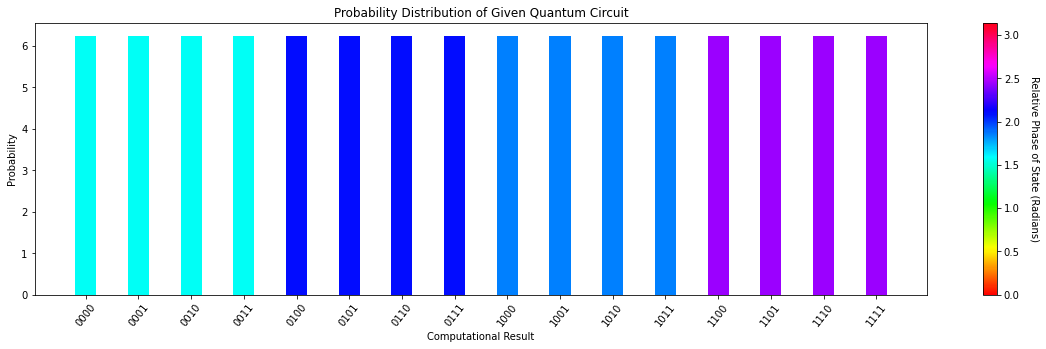

In [90]:
fig = plt.figure(figsize = (20, 5))
xVal = []
yVal = []
norm = mpl.colors.Normalize(vmin=0, vmax=np.pi)
cmap = cm.hsv
m = cm.ScalarMappable(norm=norm, cmap=cmap)
for entry in results:
    xVal.append(entry[0][::-1])
    yVal.append(entry[1]*100)
phases = [m.to_rgba(tnp.angle(np.asnumpy(results[j][2]) * 1j)) for j in range(len(results))]

df = pd.DataFrame(
   dict(
      x=xVal,
      y=yVal,
      phase=phases
   )
)

df_sorted = df.sort_values('x')
plt.bar(df_sorted['x'], df_sorted['y'], width = 0.4, color = df_sorted['phase'])
plt.xlabel("Computational Result")
plt.ylabel("Probability")
rotationAmount = math.floor(90/(1 + np.exp(-(((len(xVal))/3)-5))))
plt.xticks(rotation = rotationAmount)
cbar = plt.colorbar(m)
cbar.set_label('Relative Phase of State (Radians)', rotation=-90, labelpad=20)
plt.title("Probability Distribution of Given Quantum Circuit")
plt.show()